In [25]:
""" This module implements the base function to implement a VQE for a Ising Chain. """
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from jax.example_libraries import optimizers

import copy
import tqdm  # Pretty progress bars
import joblib, pickle  # Writing and loading

import warnings

warnings.filterwarnings(
    "ignore",
    message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.",
)

import sys, os
sys.path.insert(0, '../../')
import PhaseEstimation.circuits as circuits
import PhaseEstimation.losses as losses
######################

class vqe:
    def __init__(self, Hs, circuit):
        """
        Class for the VQE algorithm

        Parameters
        ----------
        Hs : class
            Custom Hamiltonian class
        circuit : function
            Function of the VQE circuit
        """
        self.N = Hs.N
        self.Hs = Hs
        self.n_states = Hs.n_states
        self.circuit = lambda p: circuit(self.N, p)
        self.n_params = self.circuit([0] * 10000)
        self.vqe_params = jnp.array( np.random.uniform(-np.pi, np.pi, size=(self.n_states,self.n_params)) ) 
        self.device = qml.device("default.qubit.jax", wires=self.N, shots=None)
        self.MSE = []
        self.vqe_e = []
        self.recycle = False
        self.states_dist = []

        self.circuit_fun = circuit
        
        @qml.qnode(self.device, interface="jax")
        def vqe_state(self):
            self.circuit(np.arange(self.n_params))

            return qml.state()

        self.drawer = qml.draw(vqe_state)(self)

    def train(self, lr, n_epochs, reg=0, circuit=False, save_trajectories = False, epochs_batch_size = 500, excited = False, beta = 0):
        """
        Training function for the VQE.

        Parameters
        ----------
        lr : float
            Learning rate to be multiplied in the circuit-gradient output
        n_epochs : int
            Total number of epochs for each learning
        reg : float
            Regularizer of the training function. It ensures the subsequent states are not
            too much different
        circuit : bool
            if True -> Prints the circuit
            if False -> It does not display the circuit
        plots : bool
            if True -> Display plots
            if False -> It does not display plots
        """
        # IDEA: Making the Jax version of a VQE eigensolver is a bit less intuitive that in the QCNN learning function,
        #       since here we have l_steps different circuits since each output of the circuit is <psi|H|psi> where H,
        #       changes for each datapoint.
        #       Here the output of each circuit is |psi>, while the Hs is moved to the loss function
        #       <PSI|Hs|PSI> is computed through two jax.einsum
        
        if circuit:
            # Display the circuit
            print("+--- CIRCUIT ---+")
            print(self.drawer)

        ### JAX FUNCTIONS ###
        # Circuit that returns the state |psi>
        @qml.qnode(self.device, interface="jax")
        def vqe_state(vqe_params):
            self.circuit(vqe_params)

            return qml.state()
        
        def compute_true_state(H):
            # Compute eigenvalues and eigenvectors
            eigval, eigvec = jnp.linalg.eigh(H)
            # Get the eigenstate to the lowest eigenvalue
            gstate = eigvec[:,jnp.argmin(eigval)]

            return gstate
        
        jv_compute_true_state = jax.jit(jax.vmap(compute_true_state))
        
        if excited:
            def psi_outer(psi):
                return jnp.outer(jnp.conj(psi), psi)

            outers = jax.vmap(psi_outer)(self.states)
        else:
            outers = 0
        
        # jitted vmap of the circuit
        jv_vqe_state = jax.jit(jax.vmap(lambda v: vqe_state(v), in_axes=(0)))

        # jitted circuit
        j_vqe_state = jax.jit(lambda p: vqe_state(p))

        # computes <psi|H|psi>
        def compute_E(state, Hmat):
            return jnp.conj(state) @ Hmat @ state

        # vmapped function for <psi|H|psi>
        #v_compute_E = jax.vmap(compute_E, in_axes=(0, 0))
        # jitted function for <psi|H|psi>
        j_compute_E = jax.jit(compute_E)

        # Same function as above but returns the energies not MSE
        def compute_vqe_E(param, Hmat):
            pred_states = j_vqe_state(param)
            vqe_e = j_compute_E(pred_states, Hmat)

            return jnp.real(vqe_e)

        j_compute_vqe_E = jax.jit(compute_vqe_E)
        v_compute_vqe_E = jax.vmap(compute_vqe_E, in_axes=(0, 0))

        # Computes MSE of the true energies - vqe energies: function to minimize
        def loss_reg(param, Hmat, reg, previous_state):
            pred_state = j_vqe_state(param)
            vqe_e = j_compute_E(pred_state, Hmat)

            return jnp.real(vqe_e) + reg * jnp.square(jnp.abs(jnp.conj(pred_state) @  previous_state))

        def loss(param, Hmat):
            pred_state = j_vqe_state(param)
            vqe_e = j_compute_E(pred_state, Hmat)

            return jnp.real(vqe_e)

        # Grad function of the MSE, used in updating the parameters
        jd_loss_reg = jax.jit(jax.grad(loss_reg))
        jd_loss = jax.jit(jax.grad(loss))

        def update(param, opt_state, Hmat):
            grads = jd_loss(param, Hmat)
            opt_state = opt_update(0, grads, opt_state)

            return get_params(opt_state), opt_state 

        def update_reg(param, opt_state, Hmat, reg, previous_state):
            grads = jd_loss_reg(param, Hmat, reg, previous_state)
            opt_state = opt_update(0, grads, opt_state)

            return get_params(opt_state), opt_state 

        progress = tqdm.tqdm(self.Hs.recycle_rule[1:], position=0, leave=True)
        
        params = [[0]*self.n_params]*self.n_states
        param = jnp.array(np.random.rand(self.n_params))

        vqe_e = []
        vqe_states = []
        idx = 0

        # Defining an optimizer in Jax
        opt_init, opt_update, get_params = optimizers.adam(lr)
        opt_state = opt_init(param)

        operator = qml.matrix(self.Hs.qml_Hs[idx]) + outers[idx] if excited else qml.matrix(self.Hs.qml_Hs[idx])
        
        for it in range(10*n_epochs):
            param, opt_state = update(param, opt_state, operator)
            
        previous_state = j_vqe_state(param)
        vqe_e.append(j_compute_E(previous_state, operator))        
        params[idx] = copy.copy(param)
        progress.set_description("{0}/{1}".format(idx + 1, self.n_states))

        for idx in (progress):
            opt_init, opt_update, get_params = optimizers.adam(lr)
            opt_state = opt_init(param)
            operator = qml.matrix(self.Hs.qml_Hs[idx]) + outers[idx] if excited else qml.matrix(self.Hs.qml_Hs[idx])
            
            for it in range(n_epochs):
                param, opt_state = update_reg(param, opt_state, operator, reg, previous_state)

            params[idx] = copy.copy(param)
            progress.set_description("{0}/{1}".format(idx + 1, self.n_states))
            previous_state = j_vqe_state(param)
            vqe_e.append(j_compute_E(previous_state, operator))
            
        vqe_states = jv_vqe_state(params)
        vqe_e = jnp.array(vqe_e)
        params = jnp.array(params)

        if not excited: 
            self.vqe_params = params
            self.vqe_e = vqe_e
            self.states = vqe_states
        else:
            self.vqe_params1 = params
            self.vqe_e1 = vqe_e
            self.states1 = vqe_states   

    def save(self, filename):
        """
        Save main parameters of the VQE class to a local file.
        Parameters saved:
        > Hs class, vqe parameters, circuit function

        Parameters
        ----------
        filename : str
            Local file to save the parameters
        """
        things_to_save = [
            self.Hs,
            self.vqe_params,
            self.circuit_fun
        ]

        with open(filename, "wb") as f:
            pickle.dump(things_to_save, f)


def load_vqe(filename):
    """
    Load main parameters of a VQE class saved to a local file using vqe.save(filename)

    Parameters
    ----------
    filename : str
        Local file from where to load the parameters

    Returns
    -------
    class
        VQE class with main parameters
    """
    with open(filename, "rb") as f:
        things_to_load = pickle.load(f)

    Hs, vqe_params, circuit_fun = things_to_load

    loaded_vqe = vqe(Hs, circuit_fun)
    loaded_vqe.vqe_params = vqe_params
    
    return loaded_vqe


In [26]:
def circuit_ising(N, params):
    """
    Full VQE circuit

    Parameters
    ----------
    N : int
        Number of qubits
    params: np.ndarray
        Array of parameters/rotation for the circuit

    Returns
    -------
    int
        Total number of parameters needed to build this circuit
    """
    # No wire will be measured until the end, the array of active
    # wire will correspont to np.arange(N) throughout the whole circuit
    active_wires = np.arange(N)
    index = 0
    qml.Barrier()
    for _ in range(6):
        index = circuits.circuit_ID9(active_wires, params, index)
        qml.Barrier()
        
    index = circuits.wall_gate(active_wires, qml.RX, params, index)
    
    return index

In [27]:
import PhaseEstimation.hamiltonians as hamiltonians
import PhaseEstimation.ising_chain as ising_chain

In [28]:
Hs = hamiltonians.hamiltonian(ising_chain.build_Hs, N = 8, J = 1, n_states = 100, ring = False, light = True)

In [29]:
myvqe = vqe(Hs, circuit_ising)

In [43]:
myvqe.train(.3, 300, reg = 1)

100/100: 100%|██████████████████████████████████| 99/99 [02:08<00:00,  1.29s/it]


In [44]:
import PhaseEstimation.visualization as qplt

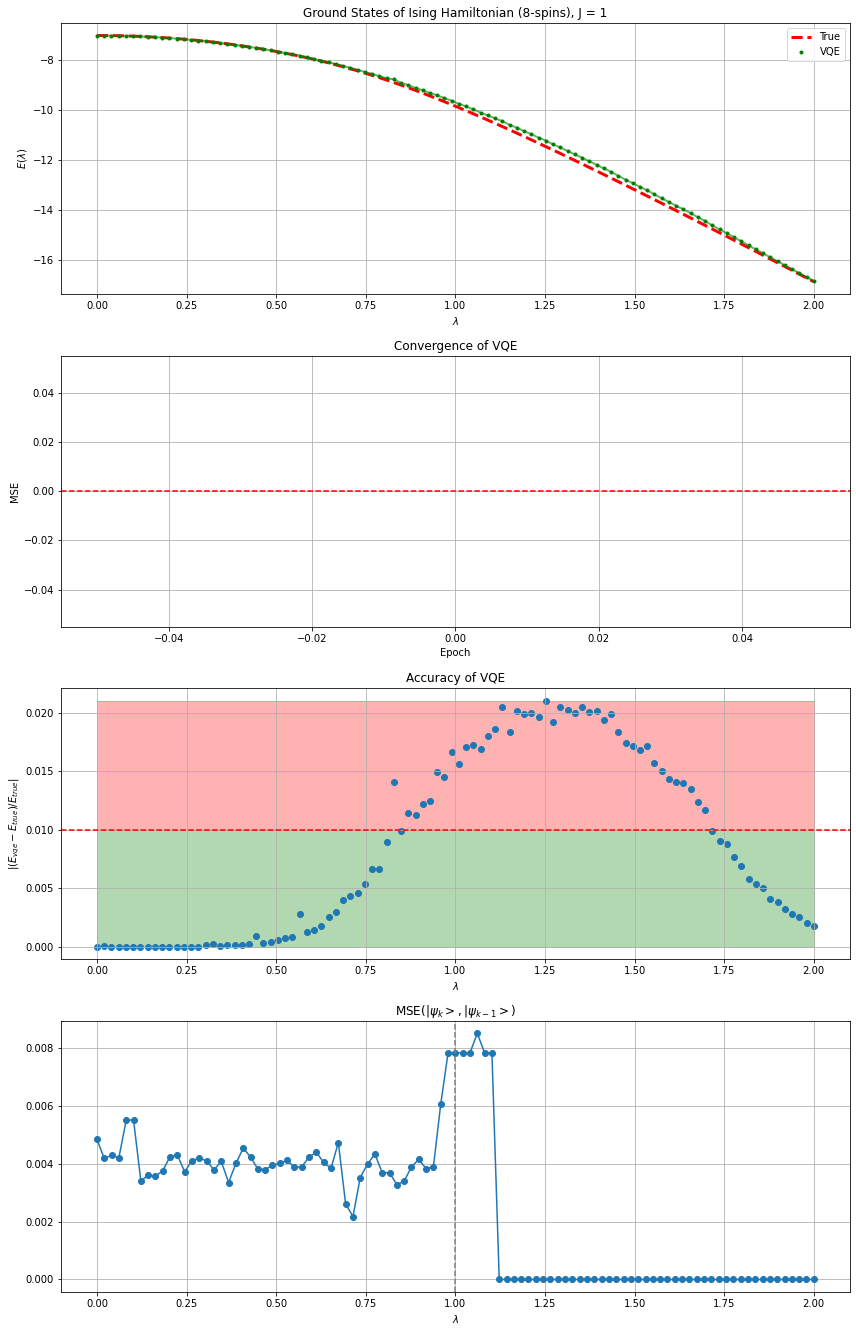

In [45]:
qplt.show_VQE_isingchain(myvqe)

In [ ]:
Hs = hamiltonians.hamiltonian(annni_model.build_Hs, N = 8, n_states = 100, ring = False, light = True)